# Adversarial Attacks

In this notebook, we will be exploring the world of adversarial attacks, where even minor modifications to the input data can cause machine learning models to make incorrect predictions. These attacks illustrate the potential vulnerabilities in systems that rely on machine learning, which raises concerns in fields such as autonomous vehicles. For example, a self-driving car could misinterpret a slightly altered stop sign. We will learn how to create adversarial examples ourselves using the Fast Gradient Sign Method (FGSM).

__Step 1:__ Load the required libraries.

In [1]:
import os
import numpy as np
import tensorflow as tf
import skimage as ski
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import concurrent.futures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D, Dropout
from keras.optimizers import Adam

:bell: You are free to add any library you deem necessary to successfully complete this homework assignment!  

For this tutorial, we will again use the Cats vs. Dogs dataset, which consists of images featuring the two distinct animal classes. To make data preprocessing easier, we have already organized the images into separate folders. You will find a 'train' folder containing images used to train your model and a 'test' folder with images for evaluating your model's performance. You can download the preprocessed dataset, [here](https://edubuas-my.sharepoint.com/:f:/g/personal/blerck_i_buas_nl/Egas9AxZzg1MrAE8f8RtErwB1Xy1CKhaNiHQX9hJjTT4Ew?e=WbD2Md). 

__Step 2:__ Download the Cats vs. Dogs dataset, and and assign the paths to the train and test set folders to the variables ```src_path_train``` and ```src_path_train```. 

In [2]:
src_path_train = '/cats_and_dogs/train' # e.g., './cats_and_dogs/train'
src_path_test = '/cats_and_dogs/test'  # e.g., './cats_and_dogs/test'

# THE IMAGES WERE NOT SEPARATED SO I HAD TO MANUALLY SPLIT THEM

__Step 3:__ Pre-process your data: 

- Rescale the images to have pixel values between 0 and 1.
- Resize the images to 224x224 pixels.
- Ensure that the images are in the correct format (e.g., RGB).
- One-hot encode the labels.
- Apply other preprocessing steps, such as horizontal flip and zoom, as necessary. 

In [3]:
# Folder paths where the images of each class are stored
folder_paths = ['cats_and_dogs/cats','cats_and_dogs/dogs']

# Class labels for the images (same order as folder_paths)
class_names = ["cats", 'dogs']

# Target size to resize the images
target_size = (224, 224)

# Arrays to store the images (X) and class labels (y)
X = []
y = []

for i in range(len(folder_paths)):
    for filename in os.listdir(folder_paths[i]):
        file_extension = os.path.splitext(filename)[1]
        # Check if the file extension is an image extension 
        if file_extension == ".jpg" or file_extension == ".jpeg" or file_extension == ".png": 
            image_filename = os.path.join(folder_paths[i], filename)
            # Read the image file using scikit-image
            image = ski.io.imread(image_filename)
            # Normalize the image to values between 0 and 1
            image = image / 255.0
            # Resize the image to the target_size
            image_resized = ski.transform.resize(image, target_size)            
            # Insert the image into array X
            X.append(image_resized)
            # Insert the class label into array y
            y.append(class_names[i])
            
# Convert of arrays into numpy arrays
X = np.array(X)
y = np.array(y)

In [4]:
data_gen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.2)

def GenerateImages(generator, image, num_images):
    new_images = []
    # we need to reshape the image because the generator.flow() 
    # expects an array of images
    image = np.reshape(image, (1,) + image.shape)
    for _ in range(num_images):
        batch = next(generator.flow(image, batch_size=1))
        new_images.append(batch[0])
    return np.array(new_images)

# Save the images to a new dataset 'X_augmented' and 'y_augmented'
X_augmented = []
y_augmented = []
for index in range(len(X)):
    images = GenerateImages(data_gen, X[index], 3)
    for i in range(3):
        X_augmented.append(images[i])
        y_augmented.append(y[index])  

# Convert lists to numpy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Encode the class labels into integers
label_encoder = LabelEncoder()
y_integer_encoded = label_encoder.fit_transform(y_augmented)  
num_classes = len(np.unique(y_integer_encoded))
y_onehot_encoded = keras.utils.to_categorical(y_integer_encoded, num_classes=num_classes)

__Step 4:__ Split your dataset into an 80% training set, 10% validation set, and 10% test set, and assign the sets to the following variables as a numpy array: ```X_train```, ```X_val```, ```X_test```, ```y_train```, ```y_val```, and ```y_test```.

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented,
                                                    y_onehot_encoded,
                                                    test_size=1/10,
                                                    random_state=0)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 1/10,
                                                  random_state = 0)

__Step 5:__ Design a Sequential model using the Keras API. Include at least one Conv2D layer for feature extraction, a Flatten layer to prepare the data for classification, and two Dense layers. Leave the second-to-last Dense layer without an activation function, but apply a softmax activation to the final output layer.

In [6]:
# Create a sequential model
model = Sequential()

# Add convolutional layers, max pooling, and dropout layers
model.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=target_size + (3,), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(10, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64))

# Output layer
model.add(Dense(2, activation='softmax'))

__Step 6:__ Compile your model, and train it using the training and validation sets.

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to monitor val_accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', 
                       patience=3)

# Train the model 
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=monitor_val_acc)

Epoch 1/100


2024-05-01 01:17:07.093829: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


228/228 [==============================] - 36s 156ms/step - loss: 0.7146 - accuracy: 0.5771 - val_loss: 0.6464 - val_accuracy: 0.6062
Epoch 2/100
228/228 [==============================] - 38s 166ms/step - loss: 0.6033 - accuracy: 0.6743 - val_loss: 0.6033 - val_accuracy: 0.6543
Epoch 3/100
228/228 [==============================] - 37s 162ms/step - loss: 0.5278 - accuracy: 0.7412 - val_loss: 0.6268 - val_accuracy: 0.6691
Epoch 4/100
228/228 [==============================] - 38s 165ms/step - loss: 0.4213 - accuracy: 0.7999 - val_loss: 0.6831 - val_accuracy: 0.6556
Epoch 5/100
228/228 [==============================] - 38s 168ms/step - loss: 0.3003 - accuracy: 0.8737 - val_loss: 0.9057 - val_accuracy: 0.6111
Epoch 6/100
228/228 [==============================] - 39s 170ms/step - loss: 0.1919 - accuracy: 0.9225 - val_loss: 1.0524 - val_accuracy: 0.6469


__Step 7:__ Load your chosen test image into a NumPy array by setting the index (e.g., ```img = X_test[4]```). Since many XAI techniques expect data in batches, we need to slightly reshape our image to add a batch dimension, even though we are only working with a single image. Use Numpy's [expand_dims()](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) method to add a new dimension at the beginning of your image array. This new dimension represents our batch size of 1, transforming the shape of the array from (224, 224, 3) to (1, 224, 224, 3). Assign the transformed image array to the variable ```img_batch```.  

In [8]:
img = X_test[21] 
img_batch =  np.expand_dims(img, axis=0)

__Step 8:__ Use your trained model to generate a prediction for the *__original version__* of the chosen image. This prediction be two probabilities (one for each class), in the form of a Numpy array that sum up to 1. Determine which of these two probabilities is higher: The class with the higher probability is the model's initial prediction. Then, save the index of the class with the higher probability in the variable ```initial_class```. Since you only have two classes, this index will be either 0 or 1.

In [9]:
predictions_original = model.predict(img_batch)

# Determine which class has the higher probability
initial_class =  np.argmax(predictions_original)

1/1 [==============================] - 0s 58ms/step


__Step 9:__ Generate the adversarial pattern, and apply the perturbations to the chosen test image by running the next code block. You may adjust the epsilon to change the level of the adversarial perturbation that is added to the original image. 

:bell: If you do not see a heatmap, the vanishing gradient problem might be the culprit. To investigate further, uncomment the ```tf.print(gradient, summarize=-1)``` line within the code block, to see the gradients. For more information on the vanishing gradient problem, see Thursday's independent study material of week 6. 

In [14]:
def create_adversarial_pattern(input_image, input_label):
    input_image = tf.convert_to_tensor(input_image)
    input_label = tf.convert_to_tensor(input_label)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.categorical_crossentropy(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    #tf.print(gradient, summarize=-1) # Prints all the gradients
    signed_gradient = tf.sign(gradient)
    return signed_gradient

label = np.array(predictions_original)

perturbations = create_adversarial_pattern(img_batch, label)
epsilon = 0.7 # Adjust epsilon as needed

img_adversarial = img_batch + epsilon * perturbations
img_adversarial = tf.clip_by_value(img_adversarial, 0, 1)

__Step 10:__ Use your trained model to generate a prediction for the *__adversarial version__* of the chosen image. This prediction be two probabilities (one for each class), in the form of a Numpy array that sum up to 1. Determine which of these two probabilities is higher: The class with the higher probability is the model's initial prediction. Then, save the index of the class with the higher probability in the variable ```adversarial_class```. Since you only have two classes, this index will be either 0 or 1.

In [15]:
predictions_adversarial = model.predict(img_adversarial)
adversarial_class =  np.argmax(predictions_adversarial)

1/1 [==============================] - 0s 21ms/step


__Step 11:__ Run the next code block to visualize the original and adversarial images side-by-side, and see the model's classification results for each. 

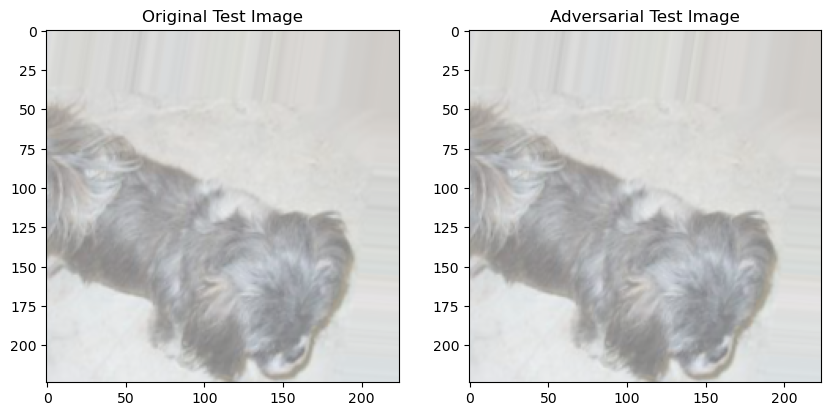

Initial prediction class: 0
[[0.8698825  0.13011743]]
Adversarial prediction class: 0
[[0.8698825  0.13011743]]


In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_batch[0] * 0.5 + 0.5)
ax[0].set_title('Original Test Image')
ax[1].imshow(img_adversarial[0] * 0.5 + 0.5)
ax[1].set_title('Adversarial Test Image')
plt.show()

print(f"Initial prediction class: {initial_class}")
print(predictions_original)
print(f"Adversarial prediction class: {adversarial_class}")
print(predictions_adversarial)